# What are LightCurve objects?

LightCurve objects are data objects which encapsulate the brightness of a star over time. They provide a series of common operations, for example folding, binning, plotting, etc. There are a range of subclasses of LightCurve objects specific to telescopes, including KeplerLightCurve for Kepler and K2 data and TessLightCurve for TESS data.

Although lightkurve was designed with Kepler, K2 and TESS in mind, these objects can be used for a range of astronomy data.

You can create a LightCurve object from a TargetPixelFile object using Simple Aperture Photometry (see our tutorial for more information on Target Pixel Files here. Aperture Photometry is the simple act of summing up the values of all the pixels in a pre-defined aperture, as a function of time. By carefully choosing the shape of the aperture mask, you can avoid nearby contaminants or improve the strength of the specific signal you are trying to measure relative to the background.

To demonstrate, lets create a KeplerLightCurve from a KeplerTargetPixelFile.

In [1]:
from lightkurve import search_targetpixelfile

# First we open a Target Pixel File from MAST, this one is already cached from our previous tutorial!
tpf = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()

# Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

We’ve built a new KeplerLightCurve object called lc. Note in this case we’ve passed an **aperture_mask** to the to_lightcurve method. The default is to use the *Kepler* pipeline aperture. (You can pass your own aperture, which is a boolean numpy array.) By summing all the pixels in the aperture we have created a Simple Aperture Photometry (SAP) lightcurve.

KeplerLightCurve has many useful functions that you can use. As with Target Pixel Files you can access the meta data very simply:

In [2]:
lc.meta['MISSION']

'Kepler'

In [3]:
lc.meta['QUARTER']

4

And you still have access to time and flux attributes. In a light curve, there is only one flux point for every time stamp:

In [4]:
lc.time

<Time object: scale='tdb' format='bkjd' value=[352.37632485 352.39675805 352.43762445 ... 442.16263546 442.18306983
 442.2035041 ]>

In [5]:
lc.flux

<Quantity [43689.15 , 43698.08 , 43694.105, ..., 43155.8  , 43148.465,
           43151.562] electron / s>

You can also check the Combined Differential Photometric Precision (“CDPP”) **noise metric of the lightcurve** using the built in method estimate_cdpp():

In [6]:
lc.estimate_cdpp()

<Quantity 75.29876612 ppm>

Now we can use the built in "plot" function on the KeplerLightCurve object to plot the time series. You can pass "plot" any keywords you would normally pass to matplotlib.pyplot.plot.

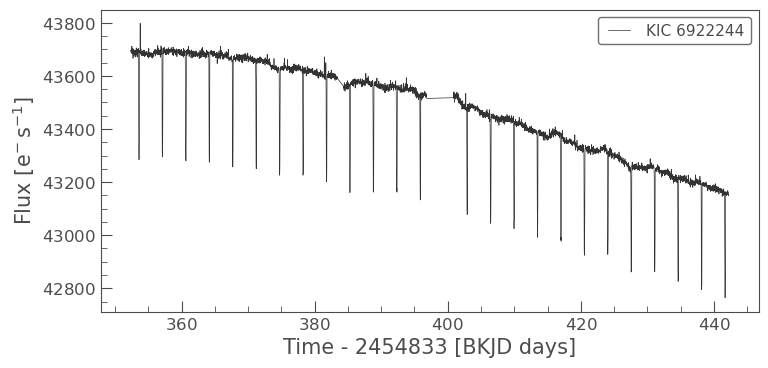

In [7]:
%matplotlib inline
lc.plot();

There are a set of useful functions in LightCurve objects which you can use to work with the data. These include:

- flatten(): Remove long term trends using a Savitzky–Golay filter
- remove_outliers(): Remove outliers using simple sigma clipping
- remove_nans(): Remove infinite or NaN values (these can occur during thruster firings)
- fold(): Fold the data at a particular period
- bin(): Reduce the time resolution of the array, taking the average value in each bin.

We can use these simply on a light curve object

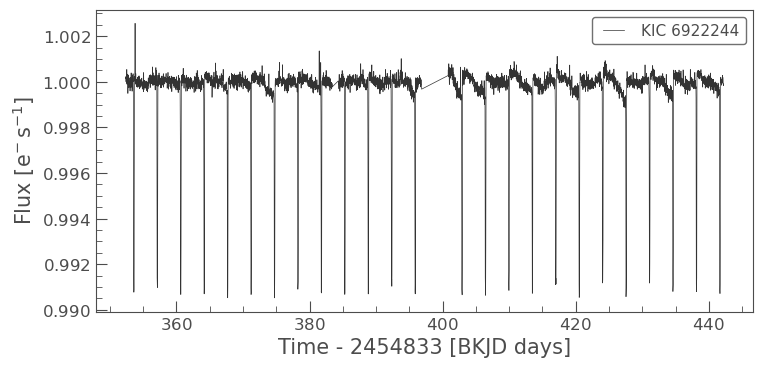

In [8]:
flat_lc = lc.flatten(window_length=401)
flat_lc.plot();

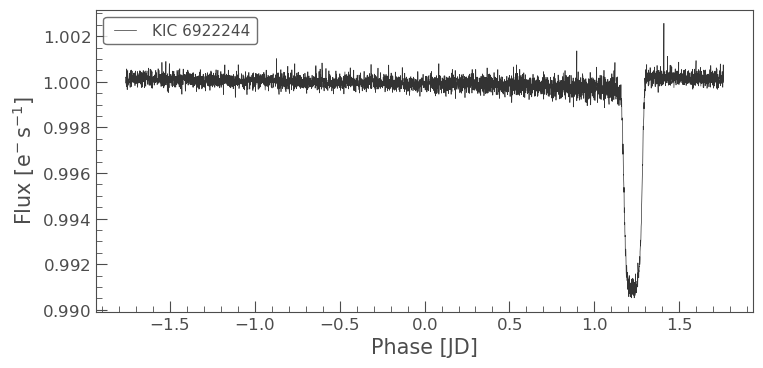

In [9]:
folded_lc = flat_lc.fold(period=3.5225)    #basically phase folding
folded_lc.plot();

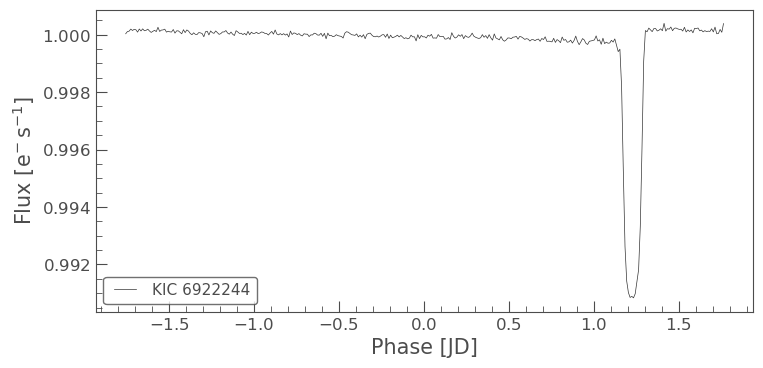

In [10]:
binned_lc = folded_lc.bin(time_bin_size=0.01)
binned_lc.plot();

Or we can do these all in a single (long) line!

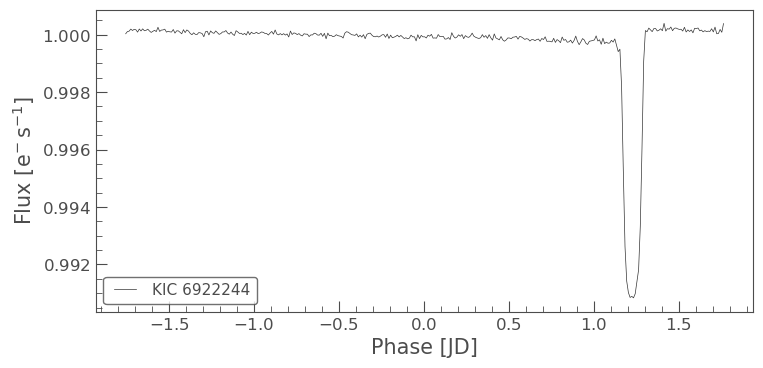

In [12]:
lc.remove_nans().flatten(window_length=401).fold(period=3.5225).bin(time_bin_size=0.01).plot();

# What are TargetPixelFile objects?

Target Pixel Files (TPFs) are a file common to Kepler/K2 and the TESS mission. They contain movies of the pixel data centered on a single target star.

TPFs can be thought of as stacks of images, with one image for every timestamp the telescope took data. Each timestamp is referred to as a **cadence**. These images are cut out ‘postage stamps’ of the full observation to make them easier to work with.

TPFs are given in FITS files, which you can read more about here. *Lightkurve* includes tools for you to work directly with these files easily and intuitively.

In this tutorial we’ll cover the basics of working with TPFs. In *lightkurve* there are classes to work with each mission. For example KeplerTargetPixelFile deals with data from the Kepler (and K2) mission. TessTargetPixelFile deals with data from the TESS mission. We’ll use a Kepler TPF as an example.

To load a KeplerTargetPixelFile from a local path or remote url, simply call Lightkurve’s read function using the location of the file as the parameter:

In [13]:
import lightkurve as lk
tpf = lk.read("https://archive.stsci.edu/pub/kepler/target_pixel_files/0069/006922244/kplr006922244-2010078095331_lpd-targ.fits.gz")

You can also search for the url automatically using the search_targetpixelfile() function. This will search for the right file in the MAST data archive which holds all of the Kepler and K2 data. In this case we want the Target Pixel File with Kepler ID 6922244 for Quarter 4 (Kepler’s observations were split into quarters of a year):

In [14]:
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile('KIC 6922244', author="Kepler", quarter=4, cadence="long").download()

You can also pass the name of the target or its astronomical coordinates as a parameter to search_targetpixelfile().

The above code has created a variable named **tpf** which is a Python object of type KeplerTargetPixelFile:

In [15]:
tpf

KeplerTargetPixelFile Object (ID: 6922244)

We can access lots of meta data using this object in a simple way. For example, we can find the mission name, and the quarter that the data was taken in by typing the following:

In [16]:
tpf.meta['MISSION']

'Kepler'

In [17]:
tpf.meta['QUARTER']

4

You can find the full list of properties in the API documentation on this object.

The most interesting data in a KeplerTargetPixelFile object are the *flux* and *time* values which give access to the brightness of the observed target over time. You can access the timestamps of the observations using the time property:

In [18]:
tpf.time

<Time object: scale='tdb' format='bkjd' value=[352.37632485 352.39675805 352.43762445 ... 442.16263546 442.18306983
 442.2035041 ]>

By default, time is in the Kepler-specific Barycentric Kepler Julian Day format (BKJD).

Because this is an **AstroPy Time object**, you access to human-readable ISO timestamps using the time.iso property:

In [19]:
tpf.time.iso

array(['2009-12-19 21:01:54.467', '2009-12-19 21:31:19.895',
       '2009-12-19 22:30:10.752', ..., '2010-03-19 15:54:11.704',
       '2010-03-19 16:23:37.233', '2010-03-19 16:53:02.754'], dtype='<U23')

**Beware:** these timestamps are in the *Solar System Barycentric frame (TDB)* and do not include corrections for light travel time or leap seconds. To use a different time scale, such as the *Earth-centered UTC system*, you can use AstroPy’s time scale conversion features. For example:

In [20]:
tpf.time.utc.iso

array(['2009-12-19 21:00:48.284', '2009-12-19 21:30:13.712',
       '2009-12-19 22:29:04.569', ..., '2010-03-19 15:53:05.518',
       '2010-03-19 16:22:31.048', '2010-03-19 16:51:56.568'], dtype='<U23')

Next, let’s look at the actual image data, which is available via the flux property:

In [21]:
tpf.flux.shape

(4116, 5, 5)

The flux data is a 4116x5x5 array in *units electrons/second*. The **first axis** is the time axis, and the **images** themselves are 5 pixels by 5 pixels. You can use the plot method on the KeplerTargetPixelFile object to view the data. (By default, this will show just one cadence of the data. But you can pass the cadence you want to look at to the *frame* keyword if you would like to check a particular flux point for thruster firings, cosmic rays or asteroids.)

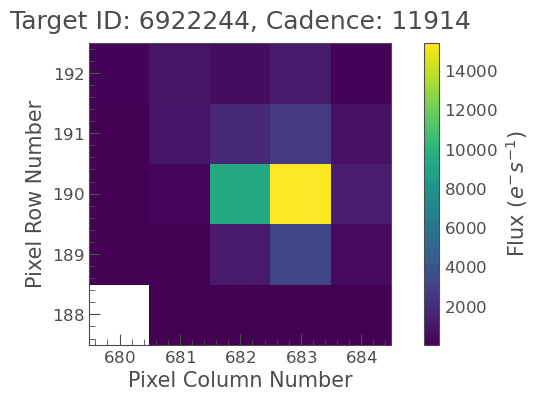

In [22]:
%matplotlib inline
tpf.plot(frame=0);

In [23]:
tpf.flux[0]

<Quantity [[          nan, 5.6079335e+00, 5.1491142e+01, 8.4241745e+01,
            3.0221334e+01],
           [4.4045620e+01, 7.6861229e+01, 1.1227759e+03, 3.2262029e+03,
            4.5486777e+02],
           [2.5911165e+01, 2.2907593e+02, 9.3626543e+03, 2.3606273e+04,
            1.2087750e+03],
           [4.0100830e+01, 8.8543927e+02, 1.7102118e+03, 2.6254871e+03,
            7.0796606e+02],
           [1.5719417e+02, 8.3713440e+02, 5.1021539e+02, 1.1501041e+03,
            1.8313370e+02]] electron / s>

You can use normal numpy methods on these to find the shape, mean etc!

We can now turn this *Target Pixel File into a light curve*, with a single flux value for every time value. Each of the pixels are 4 arcseconds across. The point spread function (PSF) of the telescope causes the light from the star fall onto several different pixels, which can be seen in the image above. Because of this spreading, we have to sum up many pixels to collect all the light from the source. To do this we sum up all the pixels in **an aperture**. An aperture is a pixel mask, where we take only the pixels related to the target.

The Kepler pipeline adds an aperture mask to each target pixel file. This aperture determines which pixels are summed to create a 1-D light curve of the target. There are some science cases where you might want to create a different aperture. For example, there may be a nearby contaminant or you may want to measure the background.

The standard pipeline aperture is easily accessed in a KeplerTargetPixelFile object using *tpf.pipeline_mask*, which is a boolean array:

In [24]:
tpf.pipeline_mask

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False,  True, False]])

We can also plot this aperture over the target pixel file above to see if the flux of the star is all contained within the aperture.

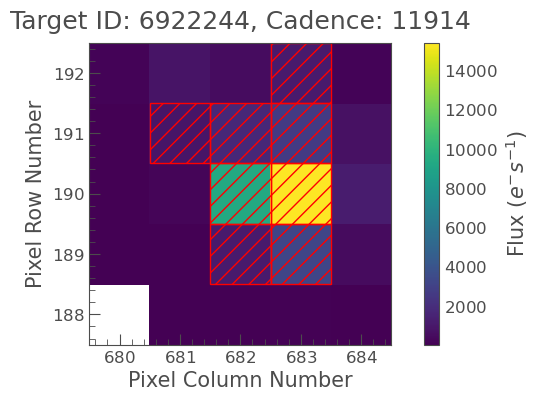

In [25]:
tpf.plot(aperture_mask=tpf.pipeline_mask);

Now that we have the aperture we can create a Simple Aperture Photometry light curve in the next tutorial.

Finally, note that you can inspect all the raw metadata of the target by taking a look at the ‘header’ of the FITS file, which contains information about the data set. Let’s just print the first 10 lines:

In [26]:
tpf.get_header()[:10]

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-23'         / file creation date.                            
CREATOR = '917482 TargetPixelExporterPipelineModule' / pipeline job and program 

We can look at the values in the second extension of the fits file by accessing the AstroPy FITS HDUList object. For example, to look at all the column titles:

In [27]:
tpf.hdu[1].header['TTYPE*']

TTYPE1  = 'TIME    '           / column title: data time stamps                 
TTYPE2  = 'TIMECORR'           / column title: barycenter - timeslice correction
TTYPE3  = 'CADENCENO'          / column title: unique cadence number            
TTYPE4  = 'RAW_CNTS'           / column title: raw pixel counts                 
TTYPE5  = 'FLUX    '           / column title: calibrated pixel flux            
TTYPE6  = 'FLUX_ERR'           / column title: 1-sigma calibrated uncertainty   
TTYPE7  = 'FLUX_BKG'           / column title: calibrated background flux       
TTYPE8  = 'FLUX_BKG_ERR'       / column title: 1-sigma cal. background uncertain
TTYPE9  = 'COSMIC_RAYS'        / column title: cosmic ray detections            
TTYPE10 = 'QUALITY '           / column title: pixel quality flags              
TTYPE11 = 'POS_CORR1'          / column title: column position correction       
TTYPE12 = 'POS_CORR2'          / column title: row position correction          
TTYPE13 = 'RB_LEVEL'        

# What are Periodogram objects?

*Lightkurve* has a class specifically for dealing with periodograms of time series data. This can be useful for finding the periods of variable stars. Below is a quick example of how to find the period of an eclipsing binary star.

First, let’s grab a light curve file from the Kepler data archive. We’ll use the object named KIC 10264202, which is an eclipsing binary observed by the original Kepler mission. We’re just going to use one quarter of data for this demo.

In [28]:
from lightkurve import search_lightcurve
lc = search_lightcurve('KIC 10264202', author="Kepler", quarter=10, cadence="long").download().remove_nans()

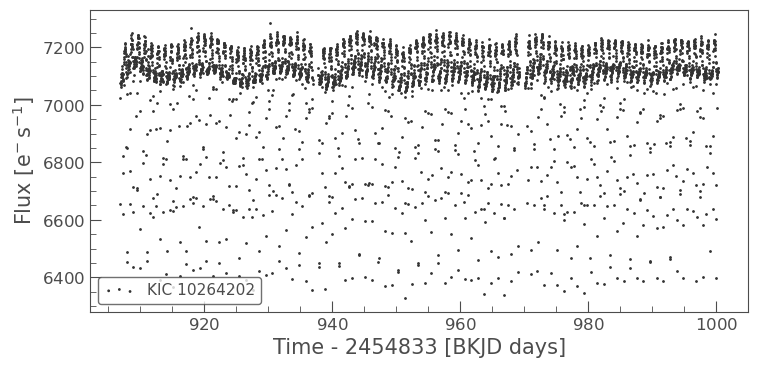

In [29]:
%matplotlib inline
lc.scatter();

This light curve looks like it has some structure in it! Let’s use the periodogram class to find the rotation period. You can create a periodogram from the KeplerLightCurve object by using the *to_periodogram* method.

In [30]:
pg = lc.to_periodogram(oversample_factor=1)
pg

LombScarglePeriodogram(ID: EPIC 212779596)

Now we can plot the periodogram in the same way that we plot the original light curve.

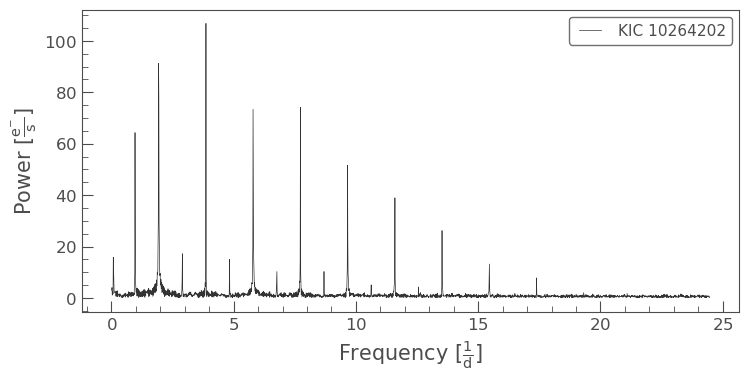

In [57]:
pg.plot();

This looks like there is a huge signal at a certain frequency! Let’s *plot it in period space*, so that we can see what period the oscillation is occurring at.

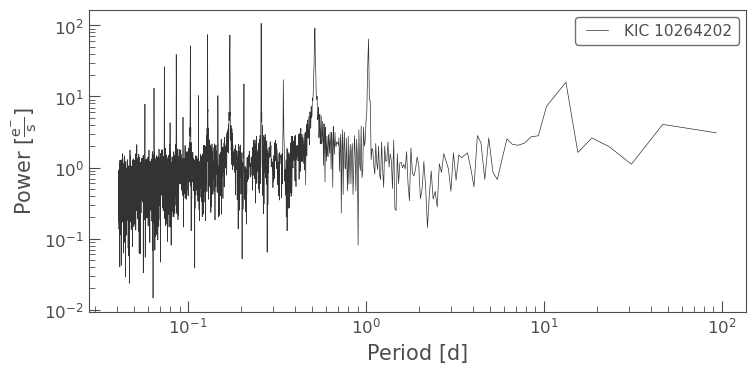

In [58]:
pg.plot(view='period', scale='log');

This looks like a very fast period. We can access the full period and power data as follows:

In [59]:
pg.period

<Quantity [9.34019490e+01, 4.67009745e+01, 3.11339830e+01, ...,
           4.09119356e-02, 4.08940232e-02, 4.08761265e-02] d>

In [60]:
pg.power

<Quantity [3.08123446, 4.04910021, 1.11686323, ..., 0.38587616, 0.17210997,
           0.42668004] electron / s>

In this case we simply want to know the **period that corresponds to the highest peak** in the periodogram. We can directly access this value using the convenient *period_at_max_power* property:

In [61]:
pg.period_at_max_power

<Quantity 0.25873116 d>

We can then use this period to fold our light curve:

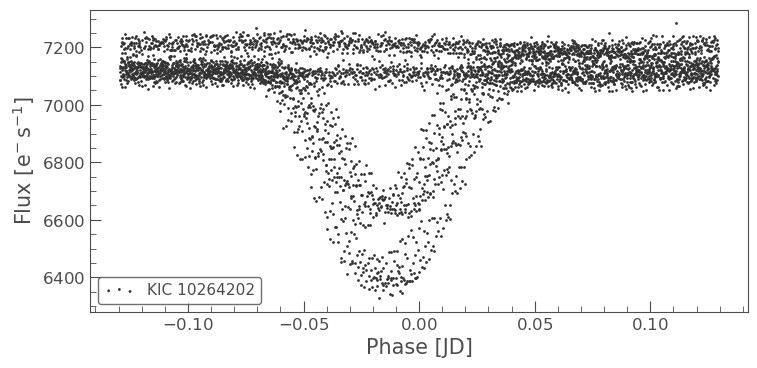

In [62]:
lc.fold(period=pg.period_at_max_power).scatter();

Oops, the eclipses do not line up nicely. This does not look like the correct period of this eclipsing binary! Interesting.

As is quite common for eclipsing binaries with deep secondary eclipses, we have found a **harmonic of the period of the eclipsing binary**. Let’s plot it again with *quadruple the period*.

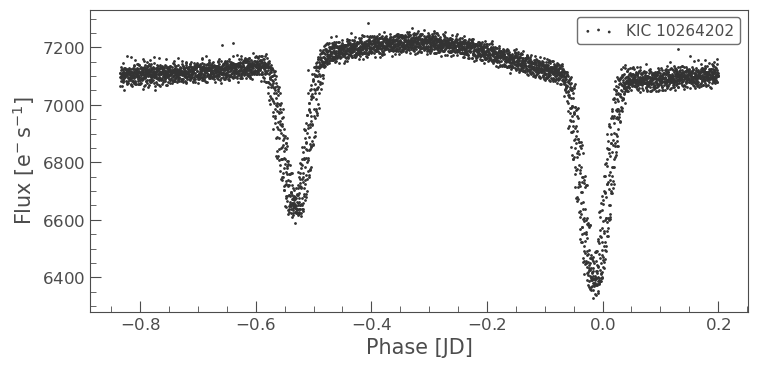

In [63]:
lc.fold(period=4*pg.period_at_max_power, wrap_phase=0.2).scatter();

That looks better, but the eclipses still don’t seem to line up as well as they could.

Let’s try to get a more precise period by increasing the number of points in our periodogram using the *oversample_factor parameter* and by *constraining the range of the period* value:

In [72]:
import astropy.units as u
pg = lc.to_periodogram(minimum_period=0.9*u.day, maximum_period=1.2*u.day, oversample_factor=10)
pg.period_at_max_power

<Quantity 1.03509717 d>

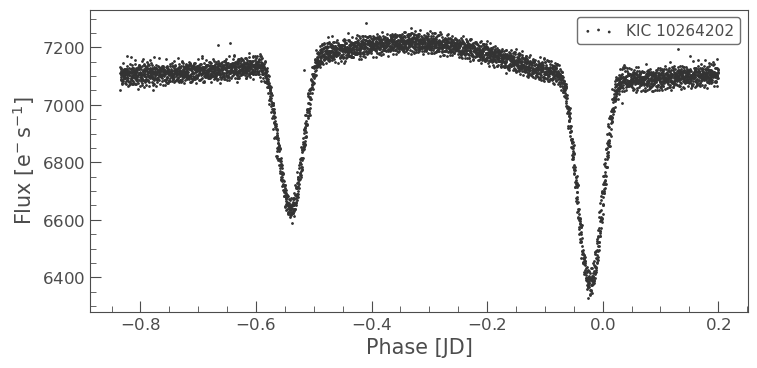

In [73]:
lc.fold(period=pg.period_at_max_power, wrap_phase=0.2).scatter();

This has improved our fit. It looks like this eclipsing binary has a period of **approximately 1 day** - check via *plot* function against either frequency/period space.

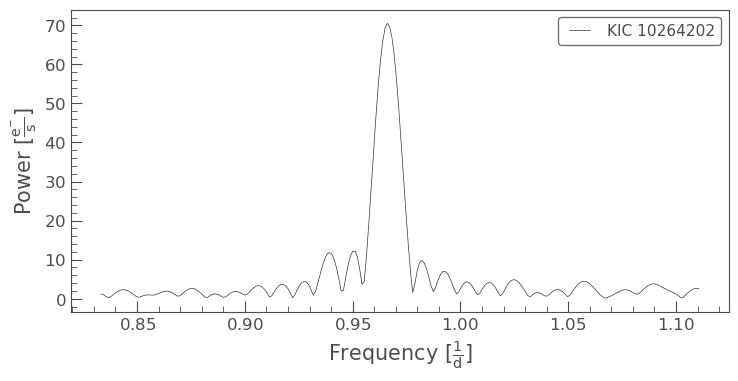

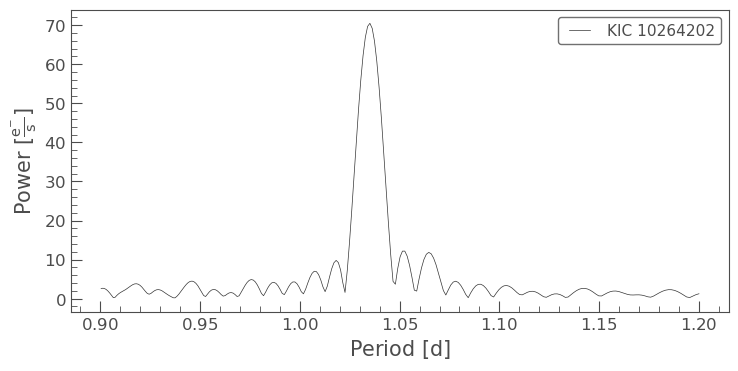

In [74]:
pg.plot(view='frequency')
pg.plot(view='period')

# Searching & downloading Kepler, K2, and TESS data

In [2]:
import lightkurve as lk
import matplotlib.pyplot as plt
%matplotlib inline

## 1. What Data Products are Available?
Kepler/K2 and TESS data products are stored on the Mikulski Archive for Space Telescopes (MAST) in two main forms:

**Light curve products**: tables containing the measured flux at each observation time.

**Target pixel file products**: stacks of images with the pixel-level observation at each observation time.

There are also the following additional products available to query and download using Lightkurve:

**High Level Science Products (HLSPs)**: a specific version of a data product produced by an analysis or photometry pipeline. Lightkurve has access to HLSP light curves produced by the photometry pipelines EVEREST, K2SFF, and K2SC. For more information about HLSPs, please see this article on the Space Telescope Science Institute’s archive.

**Full Frame Images (FFIs)**: a download of all active detector pixels at once. TESS FFIs are captured with 30-minute cadence, and custom cutouts of TESS FFIs can be queried and downloaded using Lightkurve.

Lightkurve allows you to query and download each of these data products. The following sections contain examples of how to use the search functions in Lightkurve.

## 2. Searching for Light Curves
Lightkurve uses Astroquery to search for data products. Astroquery allows searches based on a target’s coordinates, catalog ID number, or name.

This is passed into the search function using the *target* keyword, and all valid inputs for identifying a target include:

The name of the object as a string, for example, “Kepler-10.”

The KIC or EPIC identifier as an integer, for example, “11904151.”

A coordinate string in decimal format, for example, “285.67942179 +50.24130576.”

A coordinate string in sexagesimal format, for example, “19:02:43.1 +50:14:28.7.”

An astropy.coordinates.SkyCoord object.

You can also specify which mission you would like to retrieve data from using the *mission* keyword, which takes “Kepler,” “K2,” or “TESS.” By default, all available missions will be returned.

We will start with the case of searching for a Kepler target using its Kepler Input Catalog (KIC) ID number. Below, we search for KIC 3733346, an RR Lyrae star, using the *search_lightcurve* function.

In [3]:
search_result = lk.search_lightcurve('KIC 3733346', author='Kepler')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr003733346,0.0
1,Kepler Quarter 02,2009,Kepler,1800,kplr003733346,0.0
2,Kepler Quarter 03,2009,Kepler,1800,kplr003733346,0.0
3,Kepler Quarter 04,2010,Kepler,1800,kplr003733346,0.0
4,Kepler Quarter 05,2010,Kepler,1800,kplr003733346,0.0
5,Kepler Quarter 06,2010,Kepler,1800,kplr003733346,0.0
6,Kepler Quarter 07,2010,Kepler,1800,kplr003733346,0.0
7,Kepler Quarter 08,2011,Kepler,1800,kplr003733346,0.0
8,Kepler Quarter 09,2011,Kepler,1800,kplr003733346,0.0


*search_lightcurve* returns a SearchResult table, which contains information about the data products available to download. This search result tells us that KIC 3733346 was observed in Kepler Quarters 1–16.

You can select an individual entry in this search result by indexing the search result.

In [4]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 01,2009,Kepler,1800,kplr003733346,0.0


For more information about the available data products, the SearchResult has a full table accessible by calling .table. This full table contains the columns listed below. Definitions of each of these terms can be found *here (there's a hyperlink in the web)*.

In [5]:
for column in search_result.table.columns:
  print(column)

dataproduct_type
calib_level
obs_collection
obs_id
target_name
s_ra
s_dec
t_min
t_max
t_exptime
wavelength_region
filters
em_min
em_max
target_classification
obs_title
t_obs_release
instrument_name
proposal_pi
proposal_id
proposal_type
project
sequence_number
provenance_name
s_region
jpegURL
dataURL
dataRights
mtFlag
srcDen
intentType
obsid
objID
exptime
distance
obsID
obs_collection_products
dataproduct_type_products
description
type
dataURI
productType
productGroupDescription
productSubGroupDescription
productDocumentationURL
project_products
prvversion
proposal_id_products
productFilename
size
parent_obsid
dataRights_products
calib_level_products
author
mission
#
year
sort_order


These column names can also be used to search for specific entries in the table.

In [6]:
# import numpy, which we will use to find the desired index in the table
import numpy as np
quarter2_index = np.where(search_result.table['mission'] == 'Kepler Quarter 02')[0]
search_result[quarter2_index]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 02,2009,Kepler,1800,kplr003733346,0.0


You can also narrow down the list of observations when you make the search using the following mission-specific keywords: * *Kepler*: **quarter** * *K2*: **campaign** * *TESS*: **sector**

Let’s perform the search for KIC 3733346 again, this time specifying that we only want data from Kepler Quarter 2.

In [7]:
search_result_q2 = lk.search_lightcurve('KIC 3733346', author='Kepler', quarter=2)
search_result_q2

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 02,2009,Kepler,1800,kplr003733346,0.0


### 2.1 Downloading a single light curve

A light curve can be downloaded by calling .download().

In [8]:
lc = search_result_q2.download()
lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
169.7659418421681,9.2319516e+04,9.2697735e+00,0,3.263322e-03,781.81123,786.73051,2977,8.9092305e+04,8.8779488e+00,2.0773477e+03,7.0835429e-01,9.2319516e+04,9.2697735e+00,0,nan,nan,nan,nan,781.81123,1.2057812e-04,786.73051,1.4581889e-04,1.0092091e-01,-1.9298431e-01
169.7863760557957,8.9214008e+04,9.1563263e+00,0,3.263836e-03,781.80745,786.73005,2978,8.6126133e+04,8.7672691e+00,2.0793108e+03,7.0831001e-01,8.9214008e+04,9.1563263e+00,0,nan,nan,nan,nan,781.80745,1.2411721e-04,786.73005,1.5003627e-04,1.0036582e-01,-1.9279599e-01
169.80681006918894,8.5608195e+04,9.0206089e+00,0,3.264349e-03,781.80376,786.72918,2979,8.2681344e+04,8.6362791e+00,2.0772085e+03,7.0797533e-01,8.5608195e+04,9.0206089e+00,0,nan,nan,nan,nan,781.80376,1.2850568e-04,786.72918,1.5526263e-04,1.0042009e-01,-1.9289577e-01
169.8272442823436,8.3063625e+04,8.9255180e+00,0,3.264862e-03,781.80081,786.72913,2980,8.0246992e+04,8.5434341e+00,2.0767546e+03,7.0811391e-01,8.3063625e+04,8.9255180e+00,0,nan,nan,nan,nan,781.80081,1.3182692e-04,786.72913,1.5920549e-04,1.0021163e-01,-1.9266903e-01
169.84767829527118,8.4244992e+04,8.9700022e+00,0,3.265375e-03,781.80242,786.72905,2981,8.1373969e+04,8.5879698e+00,2.0805510e+03,7.0775980e-01,8.4244992e+04,8.9700022e+00,0,nan,nan,nan,nan,781.80242,1.3028238e-04,786.72905,1.5737538e-04,1.0010726e-01,-1.9241102e-01
169.86811250773462,9.7360805e+04,9.4567146e+00,0,3.265888e-03,781.81441,786.73210,2982,9.3887734e+04,9.0560179e+00,2.0782170e+03,7.0836788e-01,9.7360805e+04,9.4567146e+00,0,nan,nan,nan,nan,781.81441,1.1529749e-04,786.73210,1.3958653e-04,9.8970458e-02,-1.9224431e-01
169.88854651995644,1.2825345e+05,1.0503614e+01,0,3.266400e-03,781.83651,786.73500,2983,1.2337022e+05,1.0063412e+01,2.0774846e+03,7.0743954e-01,1.2825345e+05,1.0503614e+01,0,nan,nan,nan,nan,781.83651,9.1639682e-05,786.73500,1.1152634e-04,9.9608414e-02,-1.9224758e-01
169.90898063195345,1.5187158e+05,1.1233888e+01,0,3.266912e-03,781.84701,786.73606,2984,1.4590969e+05,1.0766508e+01,2.0792261e+03,7.0833290e-01,1.5187158e+05,1.1233888e+01,0,nan,nan,nan,nan,781.84701,7.9801415e-05,786.73606,9.7487238e-05,9.8825477e-02,-1.9200189e-01


This returns a single KeplerLightCurve object, which is shown above in the form of an astropy table. We can examine the light curve using the *plot* method.

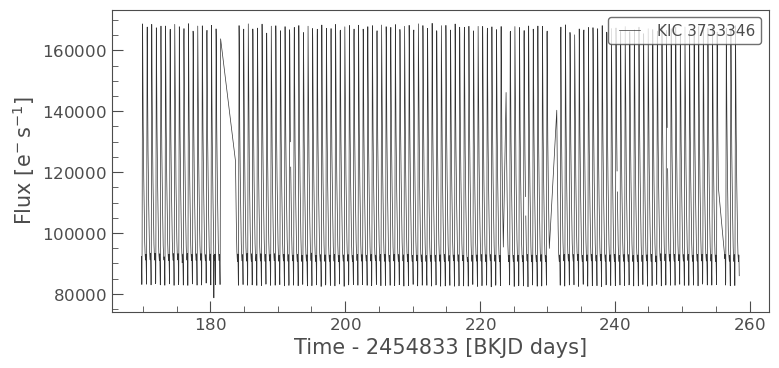

In [9]:
lc.plot();

### 2.2 Downloading a collection of light curves

The SearchResult object also has a *download_all* method, allowing you to download multiple light curves. This returns a LightCurveCollection, a convenient container for LightCurve objects.

In [10]:
lc_collection = search_result[:5].download_all()
lc_collection

LightCurveCollection of 5 objects:
    0: <KeplerLightCurve LABEL="KIC 3733346" QUARTER=1 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 3733346" QUARTER=2 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 3733346" QUARTER=3 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 3733346" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 3733346" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>

The LightCurveCollection has a number of useful functions for plotting and manipulating the light curves. For more information about how to combine multiple light curves, please see the tutorial on *combining multiple quarters* of Kepler observations.

One of the methods the collection enables you to use is *plot*, making it possible to quickly visualize all observations in your collection.

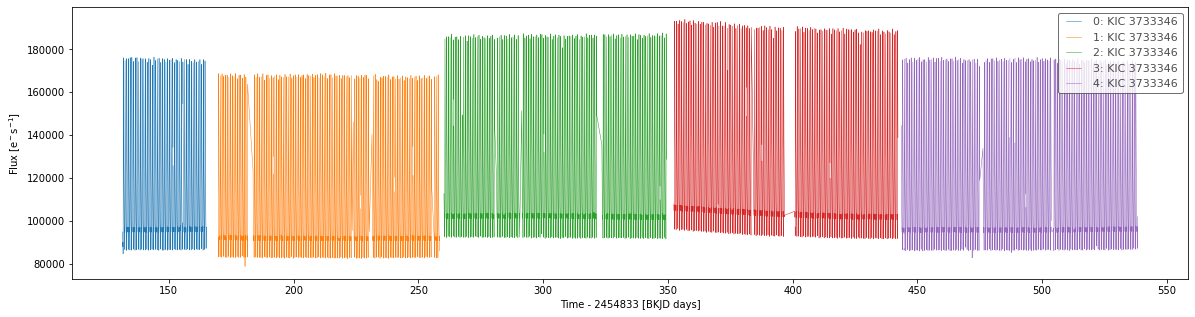

In [11]:
# Create a larger figure for clarity
fig, ax = plt.subplots(figsize=(20,5))
# Plot the light curve collection
lc_collection.plot(ax=ax);

You can also iterate through a collection to label them more clearly and to perform additional actions like normalization.

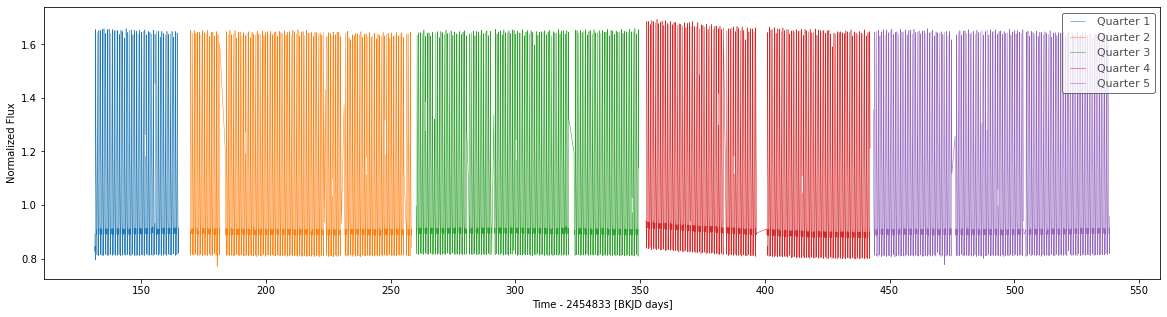

In [12]:
fig, ax = plt.subplots(figsize=(20,5))
for lc in lc_collection:
  lc.normalize().plot(ax=ax, label=f'Quarter {lc.quarter}');

## 3. Searching for Target Pixel Files

The other primary data product used by Lightkurve is the TargetPixelFile, or TPF. A TPF is a stack of images containing the flux in each pixel at each cadence.

Similar to the approach above, we can use the *search_targetpixelfile* method to identify available observations. This returns a table which contains the same information as a light curve search result.

In [15]:
search_result = lk.search_targetpixelfile('K2-199', exptime=1800)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 06,2015,K2,1800,ktwo212779596,0.0
1,K2 Campaign 17,2018,K2,1800,ktwo212779596,0.0


### 3.1 Downloading a single target pixel file

When you call *download* on a search result containing more than one entry, it will download only the first entry in the search result. Lightkurve will raise a friendly warning to let you know when this occurs.

In [18]:
tpf = search_result.download()


C:\Users\MKH\AppData\Roaming\Python\Python38\site-packages\lightkurve\search.py:346: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


We can view a single cadence of the TPF using the plot method.

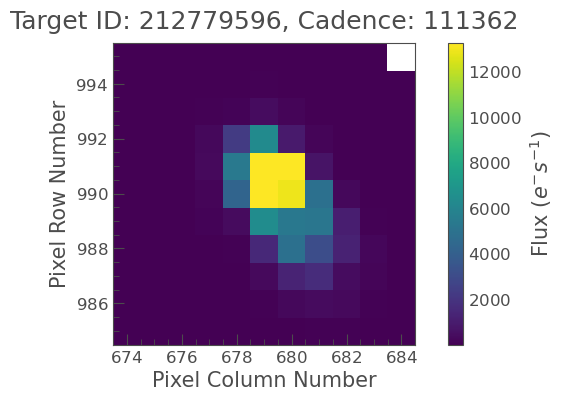

In [19]:
tpf.plot();

If we want to turn the TPF into a light curve, there is a *to_lightcurve* method.

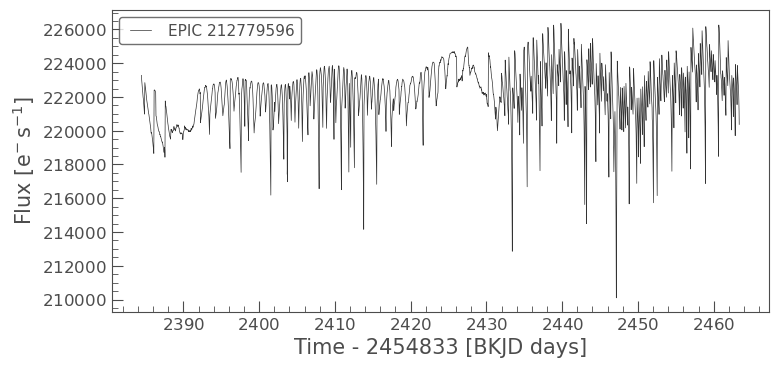

In [20]:
lc = tpf.to_lightcurve()
lc.plot();

For more information about using and plotting TPFs, please see the tutorials on using Kepler target pixel file products with Lightkurve and plotting Kepler target pixel file products with Lightkurve.

### 3.2 Downloading a collection of target pixel files

You can also download multiple TPFs at a time using the download_all method, which returns a TargetPixelFileCollection.

In [21]:
tpf_collection = search_result.download_all()
tpf_collection

TargetPixelFileCollection of 2 objects:
    0: KeplerTargetPixelFile Object (ID: 212779596)
    1: KeplerTargetPixelFile Object (ID: 212779596)

A single cadence of each of these TPFs can be inspected with the plot method.

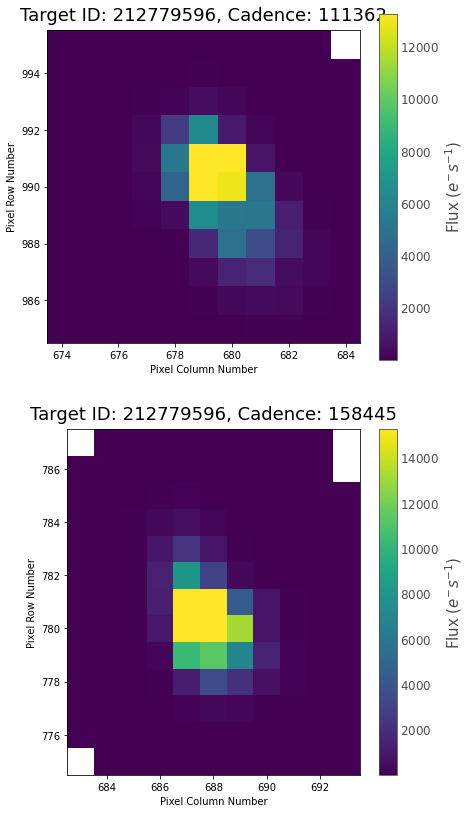

In [23]:
tpf_collection.plot();

## 4. Searching for TESS Full Frame Image (FFI) Cutouts

It is also possible to download targets observed in the TESS Full Frame Images (FFIs) using Lightkurve. This is done using *search_tesscut*, which utilizes the TESSCut tool (Brasseur et. al 2019).

In [24]:
search_result = lk.search_tesscut('Pi Men')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,TESScut,1426,Pi Men,0.0
1,TESS Sector 04,2018,TESScut,1426,Pi Men,0.0
2,TESS Sector 08,2019,TESScut,1426,Pi Men,0.0
3,TESS Sector 11,2019,TESScut,1426,Pi Men,0.0
4,TESS Sector 12,2019,TESScut,1426,Pi Men,0.0
5,TESS Sector 13,2019,TESScut,1426,Pi Men,0.0
6,TESS Sector 27,2020,TESScut,475,Pi Men,0.0
7,TESS Sector 28,2020,TESScut,475,Pi Men,0.0
8,TESS Sector 31,2020,TESScut,475,Pi Men,0.0


TESS FFI cutouts are downloaded as TargetPixelFile objects. This is done using the same download function as above, but it now takes an additional argument *cutout_size*, which describes the number of pixels along the side of the cutout, and can be an *int* or a *tuple*.

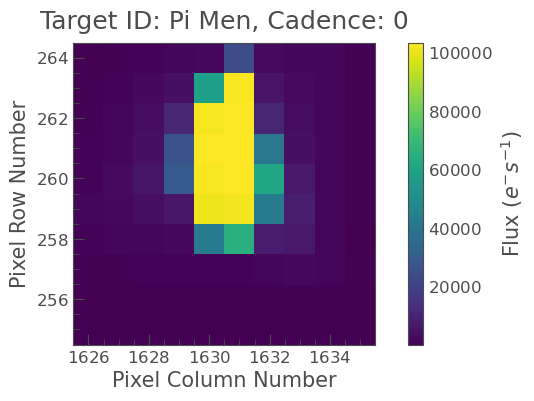

In [27]:
tpf_cutout = search_result[0].download(cutout_size=10)
tpf_cutout.plot();

## 5. Performing a Cone Search

If you are interested in identifying a number of nearby targets, you can perform a cone search, which will return all available targets within a cone of a specfied radius on the sky. The radius can be either a float or an astropy.units.Quantity object. If a float is given, it will be assumed to be in units of arcseconds. If None then we default to 0.0001 arcsec.

The *distance* column describes the distance on the sky in arcseconds from the target or coordinates passed into the search.

In [29]:
search_result = lk.search_targetpixelfile('Trappist-1', radius=180., campaign=12, exptime=1800)
print(search_result)

SearchResult containing 3 data products.

 #     mission     year author exptime  target_name  distance
                                  s                   arcsec 
--- -------------- ---- ------ ------- ------------- --------
  0 K2 Campaign 12 2016     K2    1800 ktwo246199087      0.0
  1 K2 Campaign 12 2016     K2    1800 ktwo200164267     12.1
  2 K2 Campaign 12 2016     K2    1800 ktwo246199173     95.5


## From this point onwards, we'll be strictly referring to the online guides on how to use Lightkurve - this is enough notings of the basics and we should focus on dealing with our own data products (TESS data)

## ------------------------------------------------------------------------------------------------------------------------